## While Deploying Model we must ourselves 3 questions
1. __What is my most ideal machine learning model deployment scenario ?__
2. __Where is my model going to go (cloud or on device)?__
3. __How is my model going to functions ?__ <br>
<br>
#### For Our FoodVision Mini model <br>
1. __What is the most ideal machine learning model deployment scenario ?__ <br>
> - Performs well: 95%+ accuracy
> - Fast: as close as real time (30FPS+ or 30ms latency)

2. __Where is my model going to go ?__ <br>
> 

3. __How is my model going to function ?__ <br>
>

In [4]:
import torch
import torchvision

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] couldn't find torchinfo... installing...")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except ImportError:
    print(f"[INFO] could't find going_modular scripts... downloading...")
    import os
    os.system('git clone https://github.com/pratik-kadlak/Pytorch')
    os.system('mv "Pytorch/6. Going Modular" "going_modular"')
    os.system('rm -rf Pytorch')
    from going_modular import data_setup, engine

[INFO] could't find going_modular scripts... downloading...


Cloning into 'Pytorch'...
Updating files: 100% (2962/2962), done.


In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device 

'mps'

In [7]:
# removing the current data folder in going_modular as it contains 10% data
os.system('rm -rf going_modular/data')

0

In [8]:
import os
import requests
import zipfile

def download_data(source: str, destination: str):
    """
    Downloads a zip file from the specified source URL and extracts it to the specified destination directory.

    Parameters:
    source (str): URL of the zip file to be downloaded.
    destination (str): Directory where the zip file should be extracted.
    """
    # Check if the destination directory already exists
    if not os.path.exists(destination):
        os.makedirs(destination)

    # Download the file
    print(f"[INFO] Downloading data from {source}...")
    response = requests.get(source)
    zip_path = os.path.join(destination, "data.zip")

    # Save the zip file
    with open(zip_path, "wb") as f:
        f.write(response.content)
    
    # Extract the zip file
    print(f"[INFO] Extracting data to {destination}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(destination)
    
    # Remove the zip file after extraction
    os.remove(zip_path)
    print(f"[INFO] Data downloaded and extracted to {destination}.")
    

download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
              destination="going_modular/data")

[INFO] Downloading data from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Extracting data to going_modular/data...
[INFO] Data downloaded and extracted to going_modular/data.


In [9]:
# setting up training and test paths
from pathlib import Path

data_path = Path("going_modular/data")

train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(PosixPath('going_modular/data/train'), PosixPath('going_modular/data/test'))

### What we are gonna do is make 2 models 1. Efficientnet_B2 and 2. ViT <br> Compare the results and deploy which best suits our expectation


## Creating Efficientnet_B2 

__creating dataloaders__

In [11]:
from going_modular import data_setup
from torchvision import transforms

# creating auto_transform_effnetbs
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transform = weights.transforms()


train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir, 
                                                                                                 transform=effnetb2_transform,
                                                                                                 batch_size=32)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [15]:
# creating model
from torch import nn

effnetb2 = torchvision.models.efficientnet_b2(weights=weights).to(device)

# freezing all the layers of the model
for parameter in effnetb2.parameters():
    parameter.requires_grad=False
    
# creating the last layer
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=len(class_names))
).to(device)

In [17]:
# creaing a function to create the effnetb2 model
def create_effnetb2_model():
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    
    # create transform
    effnetb2_transform = effnetb2_weights.transforms()
    
    # creating model
    effnetb2 = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    # freeze all the layers
    for param in effnetb2.parameters():
        param.requires_grad = False
        
    # create the last layer
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                  out_features=len(class_names))
    )
    
    return effnetb2, effnetb2_transform

In [26]:
effnetb2, effnetb2_transform = create_effnetb2_model()

# printing summary
summary(effnetb2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [27]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transform,
                                                                                                 batch_size=32)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

(15, 5)

In [28]:
# training the model
from going_modular import engine

# setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2, 
                                test_dataloader=test_dataloader_effnetb2,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                epochs=10)

Epoch:0	Train_Loss:0.9690	Train_Acc:54.5833	Test_Loss:0.7096	Test_Acc:94.7159
Epoch:1	Train_Loss:0.7233	Train_Acc:77.7083	Test_Loss:0.5651	Test_Acc:97.5000
Epoch:2	Train_Loss:0.5634	Train_Acc:85.6250	Test_Loss:0.4915	Test_Acc:93.8068
Epoch:3	Train_Loss:0.4446	Train_Acc:92.0833	Test_Loss:0.4334	Test_Acc:95.9659
Epoch:4	Train_Loss:0.4687	Train_Acc:87.9167	Test_Loss:0.3876	Test_Acc:97.5000
Epoch:5	Train_Loss:0.4170	Train_Acc:86.6667	Test_Loss:0.3401	Test_Acc:97.5000
Epoch:6	Train_Loss:0.3900	Train_Acc:91.0417	Test_Loss:0.3339	Test_Acc:96.5909
Epoch:7	Train_Loss:0.3299	Train_Acc:92.5000	Test_Loss:0.3229	Test_Acc:95.6818
Epoch:8	Train_Loss:0.3092	Train_Acc:94.1667	Test_Loss:0.3045	Test_Acc:95.6818
Epoch:9	Train_Loss:0.3348	Train_Acc:90.4167	Test_Loss:0.2822	Test_Acc:95.9659


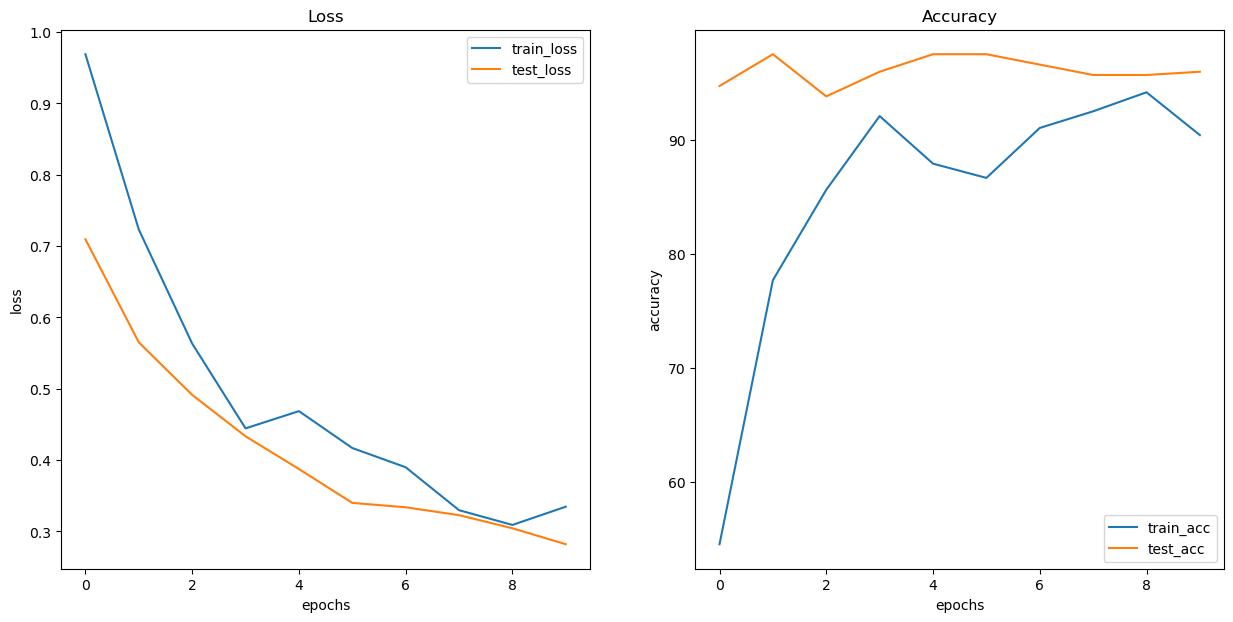

In [29]:
# plotting loss curves

import os
import sys

# Adding the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

try: 
    from helper_functions import plot_loss_curve
except ImportError:
    print(f"[INFO] Couldn't find helper_functions.py, downloading...")
    helper_functions_path = os.path.join(parent_dir, "helper_functions.py")
    with open(helper_functions_path, "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/pratik-kadlak/Pytorch/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curve
    
plot_loss_curve(effnetb2_results)

In [30]:
# saving the model
from going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor.pth


In [39]:
# getting the size of the model 
# to that we can get the idea whether this model can be deployed on edge devices or not

from pathlib import Path
effnetb2_size = round(Path("models/pretrained_effnetb2_feature_extractor.pth").stat().st_size / (1024*1024), 2)
print(f"EffnetB2_Model_Size: {effnetb2_size :.2f} MB")

EffnetB2_Model_Size: 29.83 MB


In [40]:
# count no of parameter in EffnetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

# create a stat dictionary to compare the two models later
effnetb2_stat = {"test_loss": effnetb2_results["test_loss"][-1],
                 "test_acc": effnetb2_results["test_acc"][-1],
                 "num_parameters": effnetb2_total_params,
                 "model_size (MB)": effnetb2_size}

effnetb2_stat

{'test_loss': 0.28216060996055603,
 'test_acc': 95.9659090909091,
 'num_parameters': 7705221,
 'model_size (MB)': 29.83}